In [1]:
import pandas as pd
import numpy as np
import json
import requests
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
API_KEY = os.getenv('API_KEY')

In [3]:
def pages_to_df(page,desired_year='latest'):    
    url = 'https://api.data.gov/ed/collegescorecard/v1/schools.json'
    response = requests.get(url,
                            params={'fields':'id,{year}.student,{year}.cost,{year}.aid,{year}.completion,{year}.admission,{year}.academics'.format(year=desired_year),
                                    'keys_nested':'true',
                                    'page':page,
                                    'api_key':API_KEY}
                           )
    res = response.json()
    data = res['results']
    
    json_object = json.dumps(data, indent=4)
    
    with open("../data/raw/page_{}_{}.json".format(desired_year,str(page)), "w") as outfile:
        outfile.write(json_object)

    for datum in data:
        datum['{year}'.format(year=desired_year)]['academics'].pop('program_reporter', None)
        datum['{year}'.format(year=desired_year)]['academics'].pop('program_available', None)
        datum['{year}'.format(year=desired_year)]['cost'].pop('program_reporter', None)

    df = pd.json_normalize(data)
    df_dropping = df.copy()

    completion_columns = [feat for feat in df_dropping.columns if '{year}.completion'.format(year=desired_year) in feat]
    zero_repl = dict(zip(completion_columns, np.zeros_like(completion_columns,dtype='int')))

    df_dropping = df_dropping.fillna(zero_repl)

    writing_columns = [feat for feat in df_dropping.columns if 'writing' in feat]
    df_dropping = df_dropping.drop(columns=writing_columns)

    share_columns = [feat for feat in df_dropping.columns if '{year}.student'.format(year=desired_year) in feat]
    zero_repl = dict(zip(share_columns, np.zeros_like(share_columns,dtype='int')))

    df_dropping = df_dropping.fillna(zero_repl)
    df_dropping = df_dropping.drop(columns='{year}.student.enrollment.all'.format(year=desired_year))

    public_columns = [
        feat for feat in df_dropping.columns 
        if '{year}.cost.avg_net_price.public'.format(year=desired_year) in feat
        or '{year}.cost.net_price.public'.format(year=desired_year) in feat
        or '{year}.cost.title_iv.public'.format(year=desired_year) in feat
    ]
    private_columns = [
        feat for feat in df_dropping.columns 
        if '{year}.cost.avg_net_price.private'.format(year=desired_year) in feat
        or '{year}.cost.net_price.private'.format(year=desired_year) in feat
        or '{year}.cost.title_iv.private'.format(year=desired_year) in feat
    ]
    program_columns = [
        feat for feat in df_dropping.columns 
        if '{year}.cost.avg_net_price.program_year'.format(year=desired_year) in feat
        or '{year}.cost.net_price.program_reporter'.format(year=desired_year) in feat
        or '{year}.cost.title_iv.program_reporter'.format(year=desired_year) in feat
        or '{year}.cost.title_iv.program_year'.format(year=desired_year) in feat
    ]
    other_ay_columns = [
        feat for feat in df_dropping.columns 
        if '{year}.cost.avg_net_price.other_academic_year'.format(year=desired_year) in feat
        or '{year}.cost.net_price.other_acad_calendar'.format(year=desired_year) in feat
        or '{year}.cost.title_iv.other_acad_calendar'.format(year=desired_year) in feat
        or '{year}.cost.title_iv.academic_year'.format(year=desired_year) in feat
    ]
    for i in range(len(public_columns)):
        df_dropping[public_columns[i]].fillna(df_dropping[private_columns[i]],inplace=True)
        df_dropping[public_columns[i]].fillna(df_dropping[program_columns[i]],inplace=True)
        df_dropping[public_columns[i]].fillna(df_dropping[other_ay_columns[i]],inplace=True)
    df_dropping = df_dropping.drop(columns=private_columns)
    df_dropping = df_dropping.drop(columns=program_columns)
    df_dropping = df_dropping.drop(columns=other_ay_columns)

    df_dropping['{year}.cost.attendance.academic_year'.format(year=desired_year)].fillna(
        df_dropping['{year}.cost.attendance.program_year'.format(year=desired_year)],
        inplace=True)
    df_dropping['{year}.cost.tuition.in_state'.format(year=desired_year)].fillna(
        df_dropping['{year}.cost.tuition.program_year'.format(year=desired_year)],
        inplace=True)
    df_dropping['{year}.cost.tuition.out_of_state'.format(year=desired_year)].fillna(
        df_dropping['{year}.cost.tuition.program_year'.format(year=desired_year)],
        inplace=True)
    df_dropping = df_dropping.drop(columns=['{year}.cost.attendance.program_year'.format(year=desired_year), 
                                            '{year}.cost.tuition.program_year'.format(year=desired_year)])
    
    df_renaming = df_dropping.copy()
    df_renaming.columns = df_renaming.columns.str.replace(r'{year}.'.format(year=desired_year),'',regex=True)
    df_renaming.columns = df_renaming.columns.str.replace(r'.','_',regex=True)

    url = 'https://api.data.gov/ed/collegescorecard/v1/schools.json'
    response = requests.get(url,
                            params={'fields':'id,school',
                                    'keys_nested':'true',
                                    'page':page,
                                    'api_key':API_KEY}
                           )
    res = response.json()

    data = res['results']
    
    json_object = json.dumps(data, indent=4)
    
    with open("../data/raw/schools_page_{}.json".format(str(page)), "w") as outfile:
        outfile.write(json_object)

    df_school_data = pd.json_normalize(data)
    df_school_data.columns = df_school_data.columns.str.replace(r'school.','',regex=True)
    df_school_data.columns = df_school_data.columns.str.replace(r'.','_',regex=True)
    df_school_data_drops = df_school_data.drop(columns=['zip','url','price_calculator_url',
                                                    'search','accreditor','alias','degree_urbanization'])

    df_school_data_drops = df_school_data_drops.fillna({'religious_affiliation':0})
    
    
    schools_df = df_school_data_drops.copy()
    df_info = df_renaming.copy()
    df = schools_df.merge(df_info,on='id')
    print(schools_df.shape)
    print(df_info.shape)
    print(df.shape)
    return df

In [4]:
# The data contains information for 6681, results are sent in pages of 20 items
# We will reassess if we bring in other years but let's just chill with this for now :)
6681 // 20

334

In [5]:
dfs = []
for i in range(335):
    dfs.append(pages_to_df(i))

(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)

(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)
(20, 1938)
(20, 1979)
(20, 42)

In [6]:
df = pd.concat(dfs)

In [7]:
df.shape

(6681, 1979)

This pipeline handles some of the quircky aspects of this nested data structure. Some of these columns may be `None` across the board. Some columns referring to shares of students population or completion demographics may be `0` across the board. These will be the first columns to drops.

414


<AxesSubplot:>

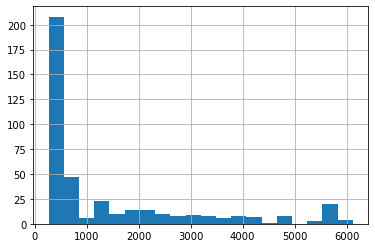

In [8]:
print(len(df.isna().sum()[df.isna().sum() > 0]))
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).hist(bins=20)

In [9]:
df.dtypes.value_counts()

float64    1401
object      415
int64        89
int32        74
dtype: int64

In [10]:
df = df.convert_dtypes()
df.dtypes.value_counts()

Float64    1270
Int64       629
Int32        74
string        5
object        1
dtype: int64

In [11]:
df.select_dtypes(include=['object','string'])

,name,city,state,accreditor_code,title_iv_approval_date,completion_separation_date_median
0,Alabama A & M University,Normal,AL,SACSCC,12/12/1965,12/31/2999
1,University of Alabama at Birmingham,Birmingham,AL,SACSCC,12/1/1965,12/31/2999
2,Amridge University,Montgomery,AL,SACSCC,3/26/1987,08/05/2016
3,University of Alabama in Huntsville,Huntsville,AL,SACSCC,12/1/1965,12/31/2999
4,Alabama State University,Montgomery,AL,SACSCC,12/1/1965,12/31/2999
...,...,...,...,...,...,...
16,Pennsylvania State University-Penn State Wilke...,Lehman,PA,MSACHE,<NA>,0
17,Pennsylvania State University-Penn State York,York,PA,MSACHE,<NA>,0
18,Pennsylvania State University-Penn State Great...,Malvern,PA,MSACHE,<NA>,0
19,Pennsylvania State University-Penn State Harri...,Middletown,PA,MSACHE,<NA>,0


`completion_separation_date_median` is discontinued... drop it

In [12]:
df = df.drop(columns='completion_separation_date_median')

In [13]:
# approval date to datetime_object
df['title_iv_approval_date'] = pd.to_datetime(df['title_iv_approval_date'],format="%m/%d/%Y")
df['title_iv_approval_date']

0    1965-12-12
1    1965-12-01
2    1987-03-26
3    1965-12-01
4    1965-12-01
        ...    
16          NaT
17          NaT
18          NaT
19          NaT
0           NaT
Name: title_iv_approval_date, Length: 6681, dtype: datetime64[ns]

In [14]:
df.dtypes.value_counts()

Float64           1270
Int64              629
Int32               74
string               4
datetime64[ns]       1
dtype: int64

As a result of the order with which I filled some `None` values with zeroes, where a `None` indicated that no data was applicable to the field, and the field represented a proportion or percentage. However, some of these fields were discontinued. I.e. the category was indicated `None` not because truly 0% of the student body fell under that category, but rather that the feature itself was discontinued as a classifier. In other words 0% of the institution's student body have x feature because 'x' feature has been renamed 'x1' or grouped in with 'x2'. Ideally, I would have liked to have more control of the fields I selected from the API, and in future iterations should consider using Data Dictionary itself to be more precise in removing unwanted columns. For now, I will remove columns with all zeroes!

In [21]:
len(df.isna().sum()[df.isna().sum() == len(df)])

0

In [30]:
dfn = df.select_dtypes(include=['Float64','Int64','Int32'])
to_check = []
for feat in dfn.columns:
    if (dfn[feat] == 0).all():
        to_check.append(feat)
to_not_drop = [feat for feat in to_check 
               if 'died' in feat or 
               'transf_unknown' in feat or 
               'academics_program_certificate_lt_4_yr_military' in feat]
to_drop = list(set(to_check).difference(set(to_not_drop)))
df = df.drop(columns=to_drop)

In [31]:
df.shape

(6681, 1936)

In [34]:
pd.set_option('display.max_rows', 500)
df.isna().sum()[df.isna().sum() > 0]

degrees_awarded_predominant_recoded                                            427
locale                                                                         554
carnegie_basic                                                                 554
carnegie_undergrad                                                             554
carnegie_size_setting                                                          554
minority_serving_historically_black                                            556
minority_serving_predominantly_black                                           556
minority_serving_annh                                                          556
minority_serving_tribal                                                        556
minority_serving_aanipi                                                        556
minority_serving_hispanic                                                      556
minority_serving_nant                                                          556
men_

Immediate takeaway... there is a lot of information missing related to SAT scores, in fact most of the information is missing. This could be a problem, but could also be really insightful if it indicates a specific point where the university stopped requiring SAT scores.
<br>Cost and aid take up a great deal of the missing values space.
<br>Missing values in the academic sections have some uniformity to them.. could be quite easy to impute. We are in an okay spot.

In [35]:
df.to_csv('../data/interim/getting_there.csv')